In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [5]:
disease_types=['COVID', 'non-COVID']
data_dir = r'E:\FYPProject\Dataset'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [7]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

1825it [00:53, 34.07it/s]

(1825, 64, 64, 3)


In [9]:
num_classes = 2
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=num_classes)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.3, random_state = 42)

In [11]:
learning_rate = 0.0001
weight_decay = 0.01
batch_size = 256
num_epochs = 2
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({
            'patch_size': self.patch_size,
        })
        
        return config

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


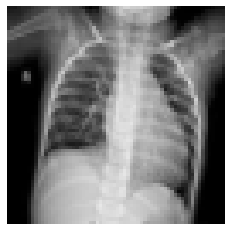

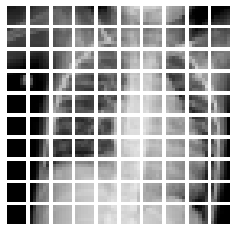

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
  

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    
    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            'num_patches': self.num_patches,
        })
        
        return config

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
input_shape = (64, 64, 3)
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    loss = tf.losses.CategoricalCrossentropy(from_logits = True)
    metrics = [keras.metrics.CategoricalAccuracy(name = "accuracy"), keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),]
    model.compile(optimizer=optimizer, loss = loss, metrics=metrics)

    checkpoint_filepath = r"E:\FYPProject\Notebooks\vitmodel.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_val, Y_val)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/2
5/5 [==============================] - 88s 12s/step - loss: 1.2565 - accuracy: 0.6205 - top-5-accuracy: 1.0000 - val_loss: 0.2438 - val_accuracy: 0.9141 - val_top-5-accuracy: 1.0000
Epoch 2/2
18/18 [==============================] - 8s 452ms/step - loss: 0.1263 - accuracy: 0.9617 - top-5-accuracy: 1.0000
Test accuracy: 96.17%
Test top 5 accuracy: 100.0%


In [19]:
custom_objects = {"Patches": Patches, "PatchEncoder": PatchEncoder}
with keras.utils.custom_object_scope(custom_objects):
    new_model = keras.models.clone_model(vit_classifier)

In [20]:
loaded_2 = keras.models.load_model(r"E:\FYPProject\Notebooks\vit.h5", custom_objects={"Patches": Patches, "PatchEncoder":PatchEncoder})
print("Loaded Model With Custome Layers/Objects", loaded_2)

Loaded Model With Custome Layers/Objects <keras.engine.functional.Functional object at 0x000001ECD1520100>


In [21]:
loaded_2.save(r"E:\FYPProject\Notebooks\vit_Loaded.h5")

In [163]:
vit_classifier.predict(X_val)

18/18 [==============================] - 11s 496ms/step


array([[ 3.7072368 , -2.4847412 ],
       [-3.97407   ,  3.729781  ],
       [ 2.3926778 , -2.6647182 ],
       ...,
       [-3.3699157 ,  0.9727932 ],
       [-0.65733504,  2.1461277 ],
       [-3.4489043 ,  4.1169    ]], dtype=float32)

In [164]:
loaded_2.predict(X_val)

18/18 [==============================] - 13s 623ms/step


array([[ 3.7072368 , -2.4847412 ],
       [-3.97407   ,  3.729781  ],
       [ 2.3926778 , -2.6647182 ],
       ...,
       [-3.3699157 ,  0.9727932 ],
       [-0.65733504,  2.1461277 ],
       [-3.4489043 ,  4.1169    ]], dtype=float32)

In [165]:
new_model.predict(X_val)

18/18 [==============================] - 12s 541ms/step


array([[ 0.21355444, -0.2312401 ],
       [-0.05354917,  0.18244219],
       [-0.09670997, -0.38368237],
       ...,
       [ 0.22975942, -0.06379938],
       [ 0.13721263,  0.07448363],
       [-0.4643063 ,  0.12218559]], dtype=float32)

In [23]:
#loaded_2.summary()

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

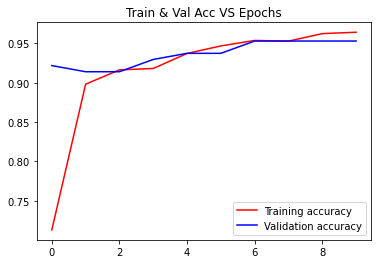

<Figure size 432x288 with 0 Axes>

In [62]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Train & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()

plt.show()

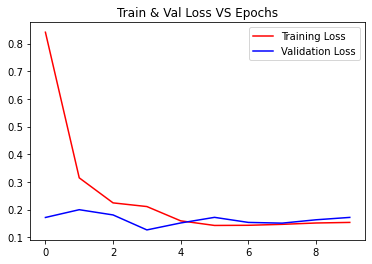

<Figure size 432x288 with 0 Axes>

In [73]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [65]:
vit_classifier.load_weights("vit.h5")
score = vit_classifier.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

18/18 [==============================] - 9s 514ms/step - loss: 0.1477 - accuracy: 0.9398 - top-5-accuracy: 1.0000
Test Loss: 0.14774459600448608
Test accuracy: 93.97810101509094


18/18 [==============================] - 17s 604ms/step


Text(0.5, 1.0, 'Confusion Matrix')

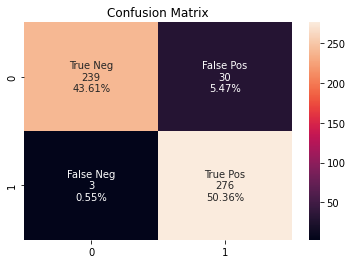

In [66]:
Y_pred = vit_classifier.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")

In [22]:
model_json = vit_classifier.to_json()
with open(r"E:\FYPProject\Notebooks\Vit_json.json", "w") as file:
    file.write(model_json)

In [4]:
print("tf.version: ", tf.version.VERSION)
print("tf.keras.version: ", tf.keras.__version__)

tf.version:  2.9.0
tf.keras.version:  2.9.0
